# Assymetrical monomers

I expect that a TLS with an RC at both the ground and excited state with different oscillator frequencies will lead to different absorption and emission transition rates at zero electromagnetic temperature. This will be completely ignored in the additive theory. How exactly is best to observe this is yet to be ironed out. 

In [34]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate, displace
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt
import scipy as sp

plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

from phonons import RC_mapping_UD
from qutip import basis, qeye, enr_identity, enr_destroy, tensor, enr_thermal_dm
from utils import *
import tests as check
import phonons


In [56]:
def ham_RC(H, CO1, CO2, COEM, 
           Omega_1, Omega_2, 
           kap_1, kap_2,
           N_1, N_2, exc):
    """ Builds RC Hamiltonian in excitation restricted subspace

    Input: System splitting, RC freq., system-RC coupling
    and Hilbert space dimension Output: Hamiltonian, all
    collapse operators in the vibronic Hilbert space
    """
    
    #I_RC_1 = qeye(N_1)
    #I_RC_2 = qeye(N_2)
    I_dim = qeye(H.shape[0])
    I = enr_identity([N_1,N_2], exc)
    shift1, shift2 = (kap_1**2)/Omega_1, (kap_2**2)/Omega_2
    H_sub = H
    
    H_sub += shift1*(CO1*CO1)
    H_sub += shift2*(CO2*CO2)
    
    #shift1, shift2 = (kap_1**2)/Omega_1, (kap_2**2)/Omega_2
    #print H_dim_sub
    H_RC = tensor(H_sub, I)

    atemp = enr_destroy([N_1,N_2], exc)

    a_RC_exc = [tensor(I_dim, aa) for aa in atemp] # annhilation ops in exc restr basis
    A_1 = a_RC_exc[0].dag() + a_RC_exc[0]
    A_2 = a_RC_exc[1].dag() + a_RC_exc[1]
    H_I1 = kap_1*tensor(CO1, I)*A_1
    H_I2 = kap_2*tensor(CO2, I)*A_2

    H_RC1 = Omega_1*a_RC_exc[0].dag()*a_RC_exc[0]
    H_RC2 = Omega_2*a_RC_exc[1].dag()*a_RC_exc[1]

    H_S = H_RC + H_RC1 + H_RC2 + H_I1 + H_I2
    return [H_sub, H_S], A_1, A_2, tensor(COEM, I)

"""print ham_RC(H, homo, lumo, sigma_x, 
           w0_h, w0_l, 
           1., 1.,
           N_h, N_l, exc)"""

def RC_mapping(H, CO1, CO2, COEM, args, silent=False):

    # we define all of the RC parameters by the underdamped spectral density
    T_1, T_2 = args['T_1'], args['T_2']
    wRC_1, wRC_2, alpha_1, alpha_2= args['w0_1'], args['w0_2'], args['alpha_1'], args['alpha_2']
    N_1, N_2, exc = args['N_1'], args['N_2'], args['exc']
    Gamma_1, Gamma_2 = args['Gamma_1'], args['Gamma_2']
    gamma_1 = Gamma_1 / (2. * np.pi * wRC_1)
    kappa_1 = np.sqrt(np.pi * alpha_1 * wRC_1 / 2.)  # coupling strength between the TLS and RC

    gamma_2 = Gamma_2 / (2. * np.pi * wRC_2)
    kappa_2 = np.sqrt(np.pi * alpha_2 * wRC_2 / 2.)
    args.update({'gamma_1': gamma_1, 'gamma_2': gamma_2, 'w0_1': wRC_1,
                    'w0_2': wRC_2, 'kappa_1':kappa_1, 'kappa_2':kappa_2})
    #print args
    H, A_1, A_2, COEM_RC = ham_RC(H, CO1, CO2, COEM, wRC_1, wRC_2, kappa_1, kappa_2, N_1, N_2, exc)
    L_RC =  phonons.liouvillian_build(H[1], A_1, A_2, gamma_1, gamma_2,  wRC_1, wRC_2,
                            T_1, T_2, num_cpus=args['num_cpus'], silent=silent)
    full_size = (4*N_1*N_2)**2
    if not silent:
        print "****************************************************************"
        note = (L_RC.shape[0], L_RC.shape[0], full_size, full_size)
        print "It is {}by{}. The full basis would be {}by{}".format(L_RC.shape[0],
                                            L_RC.shape[0], full_size, full_size)
    return -L_RC, H, A_1, A_2, COEM_RC, args




In [132]:
homo_ket = basis(2,0)
lumo_ket = basis(2,1)
homo = homo_ket*homo_ket.dag()
lumo = lumo_ket*lumo_ket.dag()

sigma_m = homo_ket*lumo_ket.dag()
sigma_x = sigma_m + sigma_m.dag()

epsilon = 8000.
T_ph= 300. # Phonon bath temperature

w0_h, w0_l = 500., 100. # underdamped SD parameter omega_0
Gamma_h = 50.
Gamma_l = 50.
alpha_h = 10.
alpha_l = 10.

print epsilon/w0_h, epsilon/w0_l

N_h, N_l = 10, 10 # set Hilbert space sizes
exc = N_l
I_s = qeye(2)
I = enr_identity([N_h, N_l], exc)

num_cpus = 1
J = J_multipolar
num_cpus = 1
bath_args = {'T_1': T_ph, 'T_2': T_ph, 
             'w0_1': w0_h, 'w0_2': w0_l, 
             'Gamma_1': Gamma_h, 'Gamma_2': Gamma_l,
             'alpha_1': alpha_h, 'alpha_2': alpha_l,
             'N_1':N_h, 'N_2':N_l, 'exc':exc, 'num_cpus':1}

H = epsilon*lumo
L_RC, H_RC, RC_h_pos, RC_l_pos, sigma_x_RC, args = RC_mapping(H, homo, -lumo, sigma_x, bath_args, silent=False)


16.0 80.0
The operators took 18.1247830391 and have dimension 128.
Building the RC Liouvillian took 18.591 seconds.
****************************************************************
It is 16384by16384. The full basis would be 160000by160000


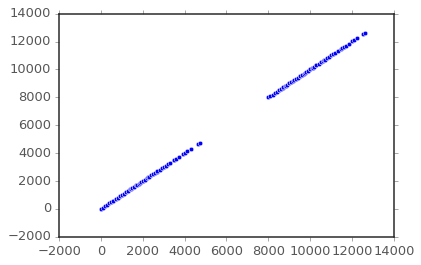

In [133]:
evals, evecs = H_RC[1].eigenstates()
plt.scatter(evals, evals)
plt.show()

### Phenomenological assymmetry 
This would allow the system RC Hamiltonian to have assymmetry, but it's unclear how to get to this from first principles (before RC mapping).

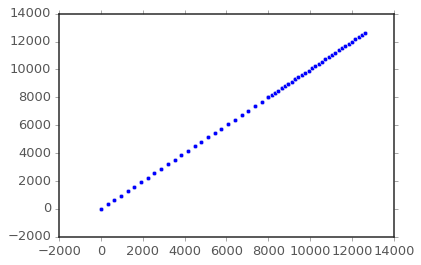

In [134]:
N, g, omega, delta  = 30, 1., 160, 160
d = destroy(N)
Hp = tensor(epsilon*lumo, qeye(N)) + g*tensor(lumo, d+d.dag())
Hp += omega*tensor(qeye(2), d.dag()*d)+ delta*tensor(homo, d.dag()*d)
evals_, evecs_ = Hp.eigenstates()
plt.scatter(evals_, evals_)
plt.show()

The coupling of the adjacent states via the identity renders the eigensystem pretty well symmetric, regardless of the oscillator frequency difference. This is rather annoying and I don't know how to stop this from happening.

## Displacing the number-restricted thermal states 
We would like to be able to start the RCs off in their equilibrium configurations, which are displaced thermal states. A problem arises in excitation number restriction, but I think that we can just write the combined thermal density matrices, calculate displacment operators in the reduced basis and then 

In [119]:

def displacement_enr(disp_1, disp_2, N_1, N_2, exc):
    # lets build displacement operators
    atemp = enr_destroy([N_1,N_2], exc)
    D_1 = (disp_1*atemp[0].dag() - disp_1.conjugate()*atemp[0]).expm()
    D_2 = (disp_2*atemp[1].dag() - disp_2.conjugate()*atemp[1]).expm()
    return D_1, D_2

kappa_h, kappa_l = args['kappa_1'], args['kappa_2']
disp_h, disp_l = kappa_h/w0_h, kappa_l/w0_l
D_1, D_2 = displacement_enr(disp_h/4, -disp_l/4, N_h, N_l, exc)
n_RC_1 = Occupation(w0_h, T_ph)
n_RC_2 = Occupation(w0_l, T_ph)
opts = qt.Options(num_cpus=num_cpus, store_states=True)
ncolors = len(plt.rcParams['axes.prop_cycle'])
thermal_RCs = enr_thermal_dm([N_h, N_l], exc, [n_RC_1, n_RC_2])
thermal_RCs = D_2*(D_1*enr_thermal_dm([N_h, N_l], exc, [n_RC_1, n_RC_2])*D_1.dag())*(D_2.dag())
#print thermal_RCs
print "Displacements: do they match? "
print (RC_h_pos*(-beta_f(T_ph)*H_RC[1]).expm()).tr(), (RC_h_pos*tensor(I_s, thermal_RCs)).tr(), disp_h, 
print (RC_l_pos*(-beta_f(T_ph)*H_RC[1]).expm()).tr(), (RC_l_pos*tensor(I_s, thermal_RCs)).tr(), -disp_l
rho_0 = tensor(lumo, thermal_RCs)
print 
#timelist = np.linspace(0,3,1000)
timelist = np.linspace(0,0.2,6000)
options = qt.solver.Options(nsteps=3000)

Displacements: do they match? 
(-1.01356488332+0j) (0.177040485855+0j) 0.177245385091 0j (-0.375546015541+0j) -0.396332729761

